<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/6.%20Modelos%20de%20Secuencias/Practica6.1.%20Modelos%20de%20texto%3A%20codificaci%C3%B3n%20one-hot%20e%20inmersiones%20de%20palabras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 6.1. Modelos de Texto

En esta práctica vamos a trabajar con las nociones básicas de modelos de texto, o también conocidos como modelos del lenguaje). Primero, haremos una introducción a las inmersiones (embeddings) de palabras, y distintas formas de procesar texto en Keras. También haremos uso de Convoluciones 1D para detectar patrones en las secuencias.

In [1]:
from tensorflow import keras
keras.__version__

'2.9.0'

## 1. Codificación one-hot de textos

La codificación **One-hot**, que ya vimos en nuestros primeros ejemplos con Keras, es la forma más sencilla de transformar texto en vectores numéricos. 

Consiste, esencialmente, en asociar un índice entero único a cada palabra, y entonces codificar la palabra por medio de un vector de $N$ componentes ($N$ es el tamaño del vocabulario) en el que hay un 1 en la posición del índice de la palabra y 0s en el resto.

A continuación se muestra una implementación manual de codificación one-hot de texto (por palabra). Este código es solo ilustrativo, después veremos cómo hacer uso de Keras para que haga ésto por nosotros.

In [ ]:
import numpy as np

# Esto es nuestros datos iniciales; una entrada por "sample"
# (en este ejemplo de juguete, un "sample" es tan solo una frase, pero
# podría ser un documento entero)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Primero, construimos un indice para todos los tokens en los datos
token_index = {}
for sample in samples:
    # Tokenizamos los samples mediante el método split.
    # En la vida real, podríamos también eliminar la puntuación
    # y los caracteres especiales de las muestras
    for word in sample.split():
        if word not in token_index:
            # Asignar un índice único a cada palabra única
            token_index[word] = len(token_index) + 1
            # Observa que no asigamos el índice 0 a nada

# A continuación, vectorizamos nuestras muestras.
# Sólo consideraremos las primeras palabras `max_length` en cada muestra.
max_length = 10

# Aquí es donde almacenamos los resultados
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.
        
print(results)

[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


Keras proporciona funciones para realizar esta codificación directamente (incluso a nivel de carácter), y es preferible usarlas porque tienen en cuenta una casuística mayor respecto a los caracteres especiales, signos de puntuación, etc. Además, estas funciones permiten definir el tamaño del vocabulario considerando únicamente las $N$ palabras más comunes del dataset e ignorando el resto.

El siguiente ejemplo muestra cómo usar el Tokenizar de Keras para preprocesar un dataset de texto (strings):

In [2]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Creamos un tokenizador, configurado para que sólo tome
# en cuenta las 1000 palabras más comunes
tokenizer = Tokenizer(num_words=1000)
# Esto construye el índice de palabras
tokenizer.fit_on_texts(samples)

# Esto convierte las cadenas en listas de índices enteros.
sequences = tokenizer.texts_to_sequences(samples)

# También se pueden obtener directamente las representaciones binarias one-hot.
# Ten en cuenta que se admiten otros modos de vectorización además de la codificación one-hot.
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# Esto es como puedes recuperar el índice de la palabra que fue calculada
word_index = tokenizer.word_index
print('Hay %s tokens distintos.' % len(word_index))

Hay 9 tokens distintos.



Hay variantes similares para reducir el tamaño del vocabulario por medio de funciones hash, pero no las veremos aquí.

## 2. Inmersiones de palabras
Otra forma habitual de asociar vectores a palabras es por medio de lo que se conocen como **inmersiones de palabras** (word embedding) o **vectorización densa**. Mientras que los vectores que se obtienen por la codificación one-hot son binarios, muy dispersos (casi todo son 0s) y de dimensión muy alta (el tamaño del vocabulario, que es fácil que alcance las decenas de miles), las inmersiones son de dimensión baja (entre 100 y 1000, aproximadamente), y con vectores de punto flotante. Además, y a difrencia del one-hot, las inmersiones se aprenden a partir de datos.

Hay dos formas de obtener estas inmersiones:

1. Aprenderlas junto con la tarea en la que se van a utilizar (por ejemplo, clasificación de documentos o análisis de sentimientos). Se sigue un proceso similar al que hemos visto al aprender los pesos de redes neuronales.
2. Usando Transfer Learning, reutilizando un modelo de inmersión que ha sido pre-entrenado usando una tarea diferente de ML.

Veremos con detalle estos dos métodos. 

### 2.1. Aprendizaje de inmersiones

Como el objetivo es que la información semántica de las palabras se refleje en el vector asociado, la asignación aleatoria de vectores a palabras, aunque posible, no tiene ninguna utilidad.

El objetivo que se persigue cuando se aprende una inmersión es que las relaciones semánticas y gramaticales existentes entre las palabras del dataset se reflejen en propiedades geométricas de los vectores. Así, dos palabras que tengan un uso/significado similar deberían asociarse a vectores cercanos.

Incluso, más allá de la simple distancia, sería deseable que las direcciones vectoriales también tengan algún significado en la inmersión. Cuando hacemos inmersiones de palabras de datasets del mundo real, resulta que las direcciones se asocian a conceptos como “plural” o “género”. Por ejemplo, si sumamos el vector “femenino” al vector asociado a la palabra “rey”, deberíamos obtener el vector asociado a la palabra “reina”, o si le sumamos el vector “plural”, obtenemos el vector asociado a la palabra “reyes”.

<img src="https://2.bp.blogspot.com/-yL_425HS2ck/WEDZLk5cq0I/AAAAAAAABcI/kwy4F4Cmfi4jyG_InIiYu6F7y2-BKTXWQCLcB/s640/embedding-mnist.gif" />

Estas características no son extrapolables a todos los problemas, y dependen de la tarea concreta que queremos resolver, así pues tiene sentido entrenar la inmersión dependiendo del tipo de tarea a resolver. Para ello Keras introduce un tipo de capa llamada *embedding*.

In [3]:
from keras.layers import Embedding

# Las capas de tipo Embedding toman al menos dos argumentos:
# el número de posibles tokens, y la dimensión de inmersión.
embedding_layer = Embedding(1000, 64)

Una capa *embedding* actúa como un diccionario que asocia índices enteros (palabras) a vectores densos. Formalmente, toma tensores 2D de enteros de tamaño `(samples, sequence_length)`, donde una entrada es una secuencia de enteros, y devuelve un tensor 3D de punto flotante de tamaño `(samples, sequence_length, embedding_dimensionality)`. Este tensor 3D puede ser procesado por las capas adecuadas (por ejemplo, una capa RNN o 1D-convolucional, como veremos más adelante).

Cuando se instancia una capa de embedding, sus pesos (diccionario interno de vectores) se inician aleatoriamente, como en cualquier otra capa. Durante el entrenamiento, estos vectores se ajustan gradualmente por medio de la retropropagación, convirtiendo el espacio de vectores en algo que el modelo puede aprovechar. Una vez entrenado, el espacio de inmersión muestra una esctructura que refleja su especialización para el problema específico para el que ha sido entrenado.

Vamos a aplicar esta idea al problema de análisis de sentimientos de las opiniones de IMDB que vimos al principio del curso. Vamos a restringirnos solamente a las 10.000 palabras más frecuentes que aparecen en las opiniones, y de cada opinión nos vamos a fijar únicamente en las primeras 20 palabras. La inmersión la haremos sobre un espacio de dimensión muy pequeña, 8D (cada palabra se convierte en un vector denso de 8 posiciones), posteriormente aplanamos esta información, y se la pasamos a una capa densa simple unitaria que realizará la clasificación:

In [9]:
from keras.datasets import imdb
from keras import utils

# Número máximo de palabras a considerar como features
max_features = 10000

# Cargar los datos como listas de enteros.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Truncaremos los textos que tengan más de `maxlen` palabras, o las rellenaremos
# con 0s hasta alcanzar este tamaño
max_len = 20

# x_train y x_test son listas de listas de enteros. Lo siguiente convierte
# nuestras listas de enteros en un tensor 2D de enteros `(samples, maxlen)``
x_train = utils.pad_sequences(x_train, maxlen=max_len)
x_test = utils.pad_sequences(x_test, maxlen=max_len)

Creamos el modelo con la capa de inmersión, y realizamos el entrenamiento con los datos leídos:
![](https://github.com/miguelamda/DL/blob/master/6.%20Redes%20Recurrentes/model1_plot.png?raw=1)

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
#from keras.utils.vis_utils import plot_model

model = Sequential()
# Especificamos la longitud máxima de entrada a nuestra capa de embedding
# para que luego podamos aplanar las entradas inmersas
model.add(Embedding(10000, 8, input_length=max_len))
# Después de la capa de embedding, 
# nuestras activaciones tienen forma `(samples, max_len, 8)`.

# Aplanamos el tensor 3D de los embeddings
# en un tensor de forma 2D `(muestras, max_len * 8)``
model.add(Flatten())

# Añadimos el clasificador en la parte superior
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
#plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten_1 (Flatten)         (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 5s 4ms/step - loss: 0.6829 - acc: 0.5709 - val_loss: 0.6568 - val_acc: 0.6610
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5761 - acc: 0.7397 - val_loss: 0.5462 - val_acc: 0.7236
Epoch 3/10
625/625 [==============================

Se consigue una precisión de validación que ronda el ~75%, lo que no está nada mal teniendo en cuenta que solo usamos 20 palabras de cada opinión (comprueba que si subes a 50, la validación alcanza el 80%). 

El modelo que hemos creado no es muy ajustado, ya que al poner una sola capa densa tras aplanar los datos hace que la posición que ocupa cada palabra no tenga ningún peso en el entrenamiento, y al perder la estructura de las frases se pierde la semántica y solo considera la aparición de ellas (por ejemplo, estas frases, que en inglés significan cosas muy distintas, las considera prácticamente iguales _“this movie is shit”_ y _“this movie is the shit”_). Para evitar este problema sería necesario usar una estructura de red que sí considerase la distribución espacial de las palabras, tal y como las convolucionales 2D hacen con las imágenes. Más adelante veremos cómo aplicar a este problema capas recurrentes o 1D convolucionales.

### 2.2. Uso de inmersiones preentrenadas

Para obtener buenos resultados en inmersiones es necesario disponer de muchos datos, pero cuando los datos que tenemos no son suficientes podemos reusar el entrenamiento realizado en otras tareas, tal y como vimos en módulos anteriores. 

Al igual que las primeras capas convolucionales de una CNN preentrenada en clases genéricas reflejan relaciones generales útiles acerca de tareas de visión para muchas otras tareas, cuando tratamos con textos, si la tarea en la que se ha entrenado la inmersión no es muy subjetiva, las relaciones geométricas de los vectores de dicha inmersión reflejarán relaciones semánticas generales entre las palabras, que muy probablemente puedan ser útiles para otras tareas que usan el mismo vocabulario.

Este tipo de inmersiones de palabras normalmente se contruyen a partir de estadísticas de ocurrencias de palabras (observaciones acerca de qué palabras co-ocurren en frases y documentos), usando diversas técnicas, algunas relacionadas con redes neuronales y otras que no. 

La idea de una inmersión de palabras densa y de baja dimensión, calculada de forma no supervisada fue inicialmente explorada por Bengio et al. a principios de los 2000, pero su uso real explotó a raíz del esquema de inmersión [Word2Vec](https://en.wikipedia.org/wiki/Word2vec), desarrollado por Mikolov en Google en 2013, que captura propiedades semánticas tales como el género, número, sinonomia, etc.

Hay varias bases de datos de inmersiones preentrenadas que se pueden descargar y usar desde las capas de inmersiones de Keras. Word2Vec es una de ellas, y [GloVe (“Global Vectors for Word Representation”)](https://nlp.stanford.edu/projects/glove/) es otra, desarrollada por investigadores de Stanford en 2014, que hace uso de factorización de matrices sobre estadísticas de co-ocurrencias a partir de millones de tokens extraídos de fuentes como la Wikipedia o Common Crawl. Puedes visualizar la inmersión en un espacio tri-dimensional en esta web https://projector.tensorflow.org.

Vamos a mostrar cómo usar GloVe en Keras, pero el procedimiento que seguiremos es extrapolable a Word2Vec y otras inmersiones.

### 2.3. Del texto en bruto a las inmersiones de palabras

Vamos a usar un modelo similar al anterior: 
* inmersión + 
* aplanamiento + 
* capa densa, 

pero esta vez usaremos una inmersión preentrenada, y en vez de usar el paquete de IMDB pre-tokenizado que proporciona Keras, haremos uso del dataset IMDB con el texto en bruto al completo.

#### Descarga de IMDB como texto

El conjunto de datos sobre el que trabajaremos se puede descargar de http://ai.stanford.edu/~amaas/data/sentiment.

En primer lugar, vamos a recolectar las opiniones individuales de entrenamiento como una lista de cadenas, una cadena para cada opinión, junto con las etiquetas asociadas (pos / neg) en una lista labels:

In [6]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xf aclImdb_v1.tar.gz

--2023-01-12 15:59:02--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  34.5MB/s    in 2.3s    

2023-01-12 15:59:05 (34.5 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [7]:
import os

# indica aquí la ruta a la carpeta descargada
imdb_dir = './aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

#### Tokenizar los datos

A continuación vamos a vectorizar los textos que hemos recolectado, y los dividiremos en conjunto de entrenamiento y de validación, de forma similar a como hemos hecho en ejemplos anteriores.

Para poner a prueba lo buenas que son las inmersiones pre-entrenadas, vamos a trabajar sobre un conjunto de entrenamiento especialmente pequeño, y consideraremos únicamente 2000 muestras.

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import numpy as np

maxlen = 100  # Recortaremos las críticas después de 100 palabras
training_samples = 2000  # Estaremos entrenando con 2000 muestras
validation_samples = 10000  # Estaremos validando con 10.000 muestras
max_words = 10000  # Sólo consideraremos las 10.000 palabras más importantes del conjunto de datos

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Encontrados %s tokens únicos.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Dividir los datos en un conjunto de entrenamiento y un conjunto de validación
# Pero primero, barajar los datos, ya que empezamos a partir de los datos
# donde se ordenan las muestras (todas negativas primero, luego todas positivas).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

xl_train = data[:training_samples]
yl_train = labels[:training_samples]
xl_val = data[training_samples: training_samples + validation_samples]
yl_val = labels[training_samples: training_samples + validation_samples]

Encontrados 88582 tokens únicos.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


#### Descargando GloVe

Vamos a utilizar la inmersión preentrenada GloVe que ha sido creada a partir de la Wikipedia en inglés en 2014 https://nlp.stanford.edu/projects/glove/. Es un fichero de 822MB llamado `glove.6B.zip`, y contiene una imersión vectorial de 100D de 400.000 palabras.

#### Preprocesando la inmersión

El fichero anterior es un `txt` que debe ser procesado para construir la asociación entre palabras (cadenas) y vectores.

In [12]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B

--2023-01-12 16:09:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-12 16:09:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-12 16:09:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [63]:
# indica aquí la ruta a la carpeta descargada
glove_dir = 'glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Encontrados %s word vectors.' % len(embeddings_index))

Encontrados 400000 word vectors.


A continuación, hemos de construir la matriz que cargaremos en la capa de inmersión. Debe tener tamaño `(max_words, embedding_dim)`, donde cada entrada $i$ contiene el vector de tamaño `embedding_dim` para la palabra $i$-ésima en el índice (construido durante la tokenización). El índice 0 no se usa para ninguna palabra.

In [64]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Las palabras no encontradas en el índice de embedding será todo cero.
            embedding_matrix[i] = embedding_vector

#### Definiendo el modelo

Usaremos la misma arquitectura que en el modelo anterior:

In [65]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                320032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### Cargando la inmersión GloVe en el modelo

La capa de inmersión tiene una matriz simple, 2D, de coma flotante, en la que cada entrada $i$ es el vector asociado a la $i$-ésima palabra. Basta cargar la matriz GloVe que hemos preparado antes en la capa de inmersión, que es la primera del modelo:

In [66]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Además, hemos de congelar los pesos de esta capa, para que el entrenamiento posterior no modifique los vectores precargados.

#### Entrenamiento y Evaluación

Compilemos y entrenemos el modelo (y lo grabamos):

In [67]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(xl_train, yl_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(xl_val, yl_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
63/63 [==============================] - 3s 33ms/step - loss: 0.7996 - acc: 0.5280 - val_loss: 0.6878 - val_acc: 0.5078
Epoch 2/10
63/63 [==============================] - 1s 20ms/step - loss: 0.6898 - acc: 0.5830 - val_loss: 0.6840 - val_acc: 0.5297
Epoch 3/10
63/63 [==============================] - 1s 16ms/step - loss: 0.6323 - acc: 0.6490 - val_loss: 0.8262 - val_acc: 0.5128
Epoch 4/10
63/63 [==============================] - 1s 13ms/step - loss: 0.5352 - acc: 0.7320 - val_loss: 0.6942 - val_acc: 0.5904
Epoch 5/10
63/63 [==============================] - 1s 12ms/step - loss: 0.4466 - acc: 0.7915 - val_loss: 0.7994 - val_acc: 0.5628
Epoch 6/10
63/63 [==============================] - 1s 13ms/step - loss: 0.3682 - acc: 0.8420 - val_loss: 0.7011 - val_acc: 0.6235
Epoch 7/10
63/63 [==============================] - 1s 13ms/step - loss: 0.2874 - acc: 0.8845 - val_loss: 0.9318 - val_acc: 0.5624
Epoch 8/10
63/63 [==============================] - 1s 12ms/step - loss: 0.2165 - a

Y mostramos su rendimiento:

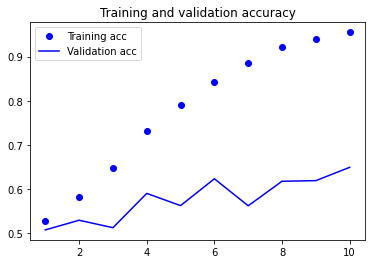

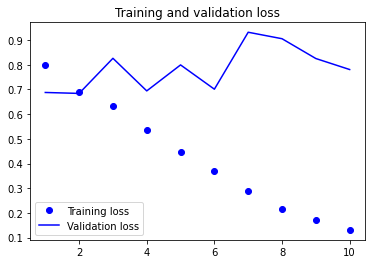

In [68]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

El modelo se sobreajusta muy rápido, algo que no es extraño teniendo en cuenta el tamaño reducido del conjunto de entrenamiento. Consecuentemente, la validación tiene una alta varianza y apenas supera el 63% en el mejor de los casos.

Observa que, debido a la selección aleatoria del pequeño conjunto de entrenamiento, los resultados pueden variar mucho si se vuelve a ejecutar el procedimiento.

También podemos intentar realizar el entrenamiento sin haber precargado una inmersión y sin congelar la capa de inmersión. Es decir, aprendiendo la inmersión específica de la tarea que estamos llevando a cabo. Esta opción, como comentamos, suele ser mejor si se dispone de los recursos computacionales necesarios y de muchos datos, pero nosotros lo entrenamos únicamente con 2000 muestras.

## 3. Usando Convolución 1D

En Keras, se puede usar una convnet 1D a través de la capa `Conv1D`, que tiene una interfaz muy similar a `Conv2D`. Toma como entrada tensores 3D con forma `(samples, time, features)` y también devuelve tensores 3D de forma similar. La ventana de convolución es una ventana 1D en el eje temporal (es decir, eje 1, *time*, en el tensor de entrada).

Las convnets 1D están estructuradas de la misma manera que sus versiones 2D que ya hemos utilizado en módulo 5: consisten en una pila de capas `Conv1D` y `MaxPooling1D`, terminando eventualmente en una capa de `globalPooling` o una capa `Flatten`, convirtiendo las salidas 3D en salidas 2D, permitiendo añadir una o más capas `Dense` al modelo, para hacer clasificación o regresión.

Una diferencia, sin embargo, es el hecho de que podemos permitirnos el lujo de usar ventanas de convolución más grandes con convnets 1D. De hecho, con una capa de convolución 2D, una ventana de convolución 3x3 contiene vectores con `3*3 = 9` características, pero con una capa de convolución 1D, una ventana de convolución de tamaño 3 sólo contendría vectores con 3 características. De esta manera podemos permitirnos fácilmente ventanas de convolución 1D de tamaño 7 o 9.

Este es nuestro ejemplo de convneto 1D para el conjunto de datos IMDB:

In [69]:
from keras.models import Sequential
from keras import layers
from keras import optimizers

modelConv1D = Sequential()
# Aquí podemos ver que podemos crear una capa de embedding con los pesos
# pre-entrenados directamente en la creación de la capa
modelConv1D.add(layers.Embedding(max_words, 
                                 embedding_dim, 
                                 input_length=maxlen,
                                 embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                 trainable=False))
modelConv1D.add(layers.Conv1D(32, 7, activation='relu'))
modelConv1D.add(layers.MaxPooling1D(5))
modelConv1D.add(layers.Conv1D(32, 7, activation='relu'))
modelConv1D.add(layers.GlobalMaxPooling1D())
modelConv1D.add(layers.Dense(1))

modelConv1D.summary()

modelConv1D.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                    loss='binary_crossentropy',
                   metrics=['acc'])
history = modelConv1D.fit(xl_train, yl_train,
                          epochs=10,
                          batch_size=32,
                         validation_data=(xl_val, yl_val))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 94, 32)            22432     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)                

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


63/63 [==============================] - 10s 30ms/step - loss: 7.8744 - acc: 0.4895 - val_loss: 7.8143 - val_acc: 0.4934
Epoch 2/10
63/63 [==============================] - 1s 15ms/step - loss: 7.8744 - acc: 0.4895 - val_loss: 7.8143 - val_acc: 0.4934
Epoch 3/10
63/63 [==============================] - 1s 15ms/step - loss: 7.8744 - acc: 0.4895 - val_loss: 7.8143 - val_acc: 0.4934
Epoch 4/10
63/63 [==============================] - 2s 25ms/step - loss: 7.8744 - acc: 0.4895 - val_loss: 7.8143 - val_acc: 0.4934
Epoch 5/10
63/63 [==============================] - 1s 17ms/step - loss: 7.8744 - acc: 0.4895 - val_loss: 7.8143 - val_acc: 0.4934
Epoch 6/10
63/63 [==============================] - 1s 15ms/step - loss: 7.8744 - acc: 0.4895 - val_loss: 7.8143 - val_acc: 0.4934
Epoch 7/10
63/63 [==============================] - 2s 25ms/step - loss: 7.8744 - acc: 0.4895 - val_loss: 7.8143 - val_acc: 0.4934
Epoch 8/10
63/63 [==============================] - 1s 15ms/step - loss: 7.8744 - acc: 0.4895

Veremos, cuando hagamos uso de redes recurrentes como la LSTM, que el tiempo de entrenamiento es muy alto. Sin embargo, el tiempo de ejecución de una Conv1D es más rápido, tanto en la CPU como en la GPU (aunque la velocidad exacta variará mucho dependiendo de la configuración).

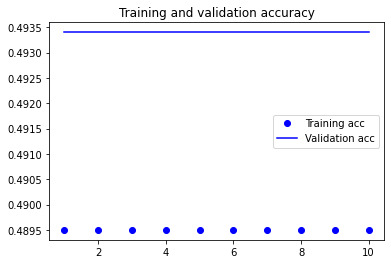

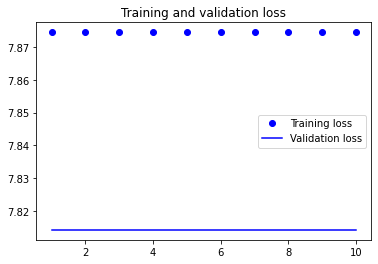

In [70]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Apenas conseguimos un 60% de accuracy en validación, un valor muy bajo que nos indica que en efecto trabajar con tan pocos ejemplos de entrenamiento lo convierte en una tarea dura.

Vamos a intentarlo de nuevo con más ejemplos, usemos el dataset IMDB que nos provee Keras, ya pre-tokenizado. Pongamos una capa de Embedding vacía.

In [71]:
modelConv1D_2 = Sequential()
modelConv1D_2.add(layers.Embedding(max_features, output_dim=128, input_length=max_len ))
modelConv1D_2.add(layers.Conv1D(32, 11, activation='relu'))
modelConv1D_2.add(layers.Conv1D(16, 7, activation='relu'))
modelConv1D_2.add(layers.GlobalMaxPooling1D())
modelConv1D_2.add(layers.Dense(1))

modelConv1D_2.summary()

modelConv1D_2.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = modelConv1D_2.fit(x_train, y_train,
                            epochs=10,
                            batch_size=128,
                            validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 32)            45088     
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 16)             3600      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,328,705
Trainable params: 1,328,705
Non-trainable params: 0
____________________________________________

Ahora mucho mejor. Conseguimos un rendimiento mucho mejor, similar al obtenido al comienzo de la práctica. Jugando con la arquitectura y los hiperparámetros podríamos conseguir una mejora sustancial.

## 4.  Usando vectorización de texto y carga de datasets de texto

Acabamos de ver una forma de tokenizar el texto un poco "manual", transformando el texto a vectores de enteros. El entrenamiento del modelo se hace directamente sobre los datos transformados. Usarla convolución 1D ayuda bastante.

Sin embargo, actualmente Keras provee una herramienta más potente para vectorizar texto, y se llama exactamente así, `TextVectorizer`. Vamos a ver cómo se simplifica el código anterior.

En el apartado 2 hemos trabajado con los datos pre-cargados en memoria (en la variable `texts`). Recuerda que `texts` era una lista de strings, que fue tokenizada a enteros en la variable `data`, y que tanto `data` como `labels` fueron desordenados. 

Vamos a ver otra forma de cargar este dataset en concreto. Para ello vamos a crear un objeto Dataset con la función [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/text_dataset_from_directory), que funciona de forma similar a como hacíamos con imágenes. Para ello, necesitamos que los datos estén estructurados por carpetas, una por cada subset (train, val, text), subcarpetas por etiqueta, y fichero de texto por cada ejemplo.

In [37]:
print("El contenido de aclImdb es: ")
!ls aclImdb/
print("El contenido de la carpeta train es: ")
!ls aclImdb/train
print("El contenido de la carpeta test es: ")
!ls aclImdb/test

El contenido de aclImdb es: 
imdbEr.txt  imdb.vocab	README	test  train
El contenido de la carpeta train es: 
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt
El contenido de la carpeta test es: 
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


Vemos que la carpeta train tiene una subcarpeta unsup (que no es ni pos ni neg, las dos etiquetas que nos atañen). Por tanto, vamos a borrar dicha carpeta para que tanto train como test solo tengan las dos subcarpetas neg y pos.

In [38]:
!rm -r aclImdb/train/unsup

A continuación vamos a cargar los ejemplos con la función que hemos comentado antes. Esta vez vamos a tener un split de 20% validación y 80% train, ya que usaremos todo el conjunto de entrenamiento.

In [39]:
batch_size = 32
raw_train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

print(f"Número de batches en raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Número de batches en raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Número de batches en raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Número de batches en raw_train_ds: 625
Número de batches en raw_val_ds: 157
Número de batches en raw_test_ds: 782


In [56]:
# Para ver un ejemplo, tenemos que acceder al dataset con un batch
ejemplo=''
for text_batch, label_batch in raw_train_ds.take(1):
  ejemplo=text_batch.numpy()[1]  # a numpy porque text_batch es un tensor

print (ejemplo)

b"I consider this film one of the worst in the Nightmare series. It was so boring that I couldn't remember a thing 20 minutes after the film was over, it even tires me to write a review on it.<br /><br />Okay, #4 was a joke and Freddy was the joker. #5 tried to return to the roots of the series. It was darker and more atmospheric than Nightmare 4, which is a good thing, basically. They tried to shoot a horror film instead of a comedy. Unfortunately they forgot to add suspense and scares. Because of that Nightmare 5: The Dream Child is neither funny nor is it scary. What we actually get is a boring film with the usual bad actors (maybe with the exception of Lisa Wilcox).<br /><br />The plot (Freddy killing Lisa's friends by using the dreams of Lisa's unborn child) has a good base but it just isn't enough for 90 minutes of film. Sometimes the story gets very confusing (maybe because there isn't any) and you can't stop wondering what the filmmakers were aiming at. The screenplay must have

Si ejecutas varias veces la celda anterior, verás que en los ejemplos se nos cuela muchas veces la etiqueta HTML `<br />`. Antes no nos hizo falta porque al tokenizar el texto a tan solo 10000 palabras, esta etiqueta se eliminó. Ahora, sí sería bueno quitarlo. Primero, nos definimos una función que estandarice nuestro texto.

In [57]:
import tensorflow as tf
import string
import re

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data) #a minúscula
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")  # quita <br /> y lo reemplaza por un espacio.
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", "" # quita signos de puntuación
    )

# aplicado al ejemplo anterior
custom_standardization(ejemplo)


<tf.Tensor: shape=(), dtype=string, numpy=b'i consider this film one of the worst in the nightmare series it was so boring that i couldnt remember a thing 20 minutes after the film was over it even tires me to write a review on it  okay 4 was a joke and freddy was the joker 5 tried to return to the roots of the series it was darker and more atmospheric than nightmare 4 which is a good thing basically they tried to shoot a horror film instead of a comedy unfortunately they forgot to add suspense and scares because of that nightmare 5 the dream child is neither funny nor is it scary what we actually get is a boring film with the usual bad actors maybe with the exception of lisa wilcox  the plot freddy killing lisas friends by using the dreams of lisas unborn child has a good base but it just isnt enough for 90 minutes of film sometimes the story gets very confusing maybe because there isnt any and you cant stop wondering what the filmmakers were aiming at the screenplay must have had mor

A continuación, creamos una capa nueva que será la primera de un modelo. Esta capa es de tipo `TextVectorization`, y le indicamos la función para limpiar el texto definida arriba (por defecto también hace limpieza de signos de puntuación, pero nosotros queríamos quitar también las `<br />`), el número máximo de tokens (palabras) a tener en cuenta (sigamos con 10000, como antes), y el tamaño máximo de secuencia (como antes, vamos a poner 100). LA salida serán enteros (one-hot).

In [58]:
from keras.layers import TextVectorization

# Creamos la capa de tipo TextVectorization. Indicamos el máximo número de palabras y la longitud máxima de secuencia
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_words,
    output_mode="int",
    output_sequence_length=maxlen,
)

# Hagamos un dataset de solo texto (sin etiquetas)
text_ds = raw_train_ds.map(lambda x, y: x)
# Llamemos al método adapt, que creará el vocabulario (mapeo de las 10000 palabras a un entero)
vectorize_layer.adapt(text_ds)


Una vez hemos creado la capa de vectorización, y hemos calculado el vocabulario (palabra - número) con el método `adapt`, podemos añadirla al modelo. Primero metemos una capa de entrada de tipo string, y luego la de vectorización. El resto de modelo será igual que antes. Ahora sí, veremos que el entrenamiento es más lento que antes, por dos razones: el conjunto de train es mucho más grande, y el proceso de tokenización se hace sobre la marcha. Dado que usamos más ejemplos, veremos una mejora en la precisión del modelo.

In [73]:
modelConv1D_3 = Sequential()
# Necesitamos meter una capa de entrada indicando que recibirá texto
modelConv1D_3.add(keras.Input(shape=(1,), dtype=tf.string, name='text'))
# A continuación, esta capa pasará por la capa de vectorización
modelConv1D_3.add(vectorize_layer)
# El resto de capas queda igual que en el primer ejemplo de convolución 1D
modelConv1D_3.add(layers.Embedding(max_words, 
                                   embedding_dim, 
                                   input_length=maxlen,
                                   embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                   trainable=False))
modelConv1D_3.add(layers.Conv1D(32, 7, activation='relu'))
modelConv1D_3.add(layers.MaxPooling1D(5))
modelConv1D_3.add(layers.Conv1D(32, 7, activation='relu'))
modelConv1D_3.add(layers.GlobalMaxPooling1D())
modelConv1D_3.add(layers.Dense(1))

modelConv1D_3.summary()

modelConv1D_3.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                    loss='binary_crossentropy',
                   metrics=['acc'])
history = modelConv1D_3.fit(raw_train_ds, 
                          epochs=10,
                          batch_size=32,
                         validation_data=(raw_val_ds))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 conv1d_4 (Conv1D)           (None, 94, 32)            22432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 12, 32)            7200      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


625/625 [==============================] - 39s 61ms/step - loss: 1.2461 - acc: 0.4994 - val_loss: 0.7384 - val_acc: 0.5092
Epoch 2/10
625/625 [==============================] - 20s 31ms/step - loss: 0.7164 - acc: 0.5397 - val_loss: 0.7330 - val_acc: 0.5284
Epoch 3/10
625/625 [==============================] - 26s 41ms/step - loss: 0.6793 - acc: 0.5761 - val_loss: 0.7315 - val_acc: 0.5358
Epoch 4/10
625/625 [==============================] - 35s 56ms/step - loss: 0.6523 - acc: 0.6108 - val_loss: 0.7493 - val_acc: 0.5386
Epoch 5/10
625/625 [==============================] - 25s 39ms/step - loss: 0.6296 - acc: 0.6374 - val_loss: 0.7507 - val_acc: 0.5492
Epoch 6/10
625/625 [==============================] - 30s 47ms/step - loss: 0.6098 - acc: 0.6607 - val_loss: 0.7735 - val_acc: 0.5478
Epoch 7/10
625/625 [==============================] - 26s 41ms/step - loss: 0.5924 - acc: 0.6758 - val_loss: 0.7470 - val_acc: 0.5580
Epoch 8/10
625/625 [==============================] - 33s 53ms/step - los

Finalmente, lo podemos evaluar sobre el subconjunto de test. No necesitamos preprocesar el texto ya que la capa de vectorización hace todo el proceso automáticamente.

In [74]:
modelConv1D_3.evaluate(raw_test_ds)

782/782 [==============================] - 47s 59ms/step - loss: 0.7707 - acc: 0.5725


[0.7706998586654663, 0.5725200176239014]